In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, time, datetime
import time

In [2]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import ElementNotInteractableException, StaleElementReferenceException

In [3]:
import shutil

__ALWAYS RUN FIRST__

Setting correct date for data

Hour references in the code are set for PST, please change if your current timezone is different

In [4]:
today = date.today()
now = datetime.now()
hour = now.hour
day = today.weekday()
weekday = True
day_dic = {0: 'Monday', 1: 'Tueday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
day_name = day_dic[day]
print('Hour references in the code are set for PST, please change if your current timezone is different.')
print(f'It is {day_name} {now} now.')
day_name = day_dic[today.weekday()]
if day > 4:
    print(f'It is the weekend {day_name} {today}.')
    print('Organizing data gathered for the last week.')
    weekday = False
    #today = today - timedelta(days = day-4)
elif day <= 4:
    print(f'Gathering data for {day_name} {today}.')
elif 0 <= hour < 6:
    today = today - timedelta(days = 1)
elif 6 <= hour < 13:
    raise Exception('Market is currently in trading hours, please wait until it closes to gather data.')

Hour references in the code are set for PST, please change if your current timezone is different.
It is Friday 2021-10-22 13:05:48.628236 now.
Gathering data for Friday 2021-10-22.


Closing price and trade volume (cptv) by minute datatable

In [5]:
def get_cptv():
    adv_chart_url = 'https://www.nasdaq.com/market-activity/stocks/amzn/advanced-charting/'
    driver.get(adv_chart_url)
    driver.switch_to.window(driver.window_handles[0])
    driver.switch_to.default_content()

    graph_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
    driver.switch_to.frame(graph_frame)
    period_button = driver.find_element_by_id('periodBtn')
    ActionChains(driver).move_to_element(period_button).click().perform()
    min_period = driver.find_element_by_xpath('//*[@id="periodicity"]/li[5]')
    ActionChains(driver).move_to_element(min_period).click().perform()
    table_button = driver.find_element_by_id("dataTableBtn")
    table_button.click()
    driver.switch_to.default_content()
    table_frame = driver.find_element_by_xpath('//*[@id="chartholder"]/iframe')
    driver.switch_to.frame(table_frame)
    wait = WebDriverWait(driver, 10)
    export_to_excel_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@onclick="window.grid.exportToExcel()"]')))
    ActionChains(driver).move_to_element(export_to_excel_button).click().perform()

Moving downloaded cptv by minute datatable to correct folder

Real time trades datatable

In [6]:
def get_rtt():
    real_time_trades_url = 'https://www.nasdaq.com/market-activity/stocks/amzn/latest-real-time-trades'
    driver.get(real_time_trades_url)
    driver.switch_to.window(driver.window_handles[0])
    driver.switch_to.default_content()

    time.sleep(2)
    time_list = ['9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
    dropdown_menu = driver.find_element_by_class_name('latest-real-time-trades__dropdown-toggle')
    dropdown_buttons = driver.find_elements_by_class_name('latest-real-time-trades__dropdown-option')
    next_page_button = driver.find_element_by_class_name("pagination__next")
    banner = driver.find_element_by_xpath("/html/body")
    real_time_trades_data = []

    table_page_buttons = driver.find_elements_by_class_name("pagination__page")
    if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
        driver.execute_script("window.scrollBy(0, -200);")
    ActionChains(driver).move_to_element(table_page_buttons[0]).click().perform()

    row_count = 0

    for i, time_section in enumerate(time_list):
        driver.execute_script("window.scroll(0, 0);")
        driver.execute_script("arguments[0].scrollIntoView();", dropdown_menu)
        time_section_clicked = False
        while time_section_clicked == False:

            try:
                if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
                    driver.execute_script("window.scrollBy(0, -200);")
                ActionChains(driver).move_to_element(dropdown_menu).click().perform()
                driver.execute_script("arguments[0].scrollIntoView();", dropdown_buttons[i+1])
                ActionChains(driver).move_to_element(dropdown_buttons[i+1]).click().perform()
                time_section_clicked = True
            except ElementNotInteractableException:
                driver.execute_script("window.scrollBy(0, -200);")
                continue
        print(time_section)


        pages = 1
        while next_page_button.is_enabled() == True:

            ## function?
            row_count -= 1
            page_data_gathered = False
            row_count_buffer = 0
            data_buffer = []
            while page_data_gathered == False:
                try:
                    real_time_trades_row = driver.find_elements_by_xpath('.//*[self::tr]')
                    for i, row in enumerate(real_time_trades_row):
                        data_row = []
                        for j, item in enumerate(row.find_elements_by_xpath(".//*[self::td or self::th]")):
                            data_row.append(item.text)
                        row_count_buffer += 1
                        data_buffer.append(data_row)
                    page_data_gathered = True
                except StaleElementReferenceException:
                    row_count_buffer = 0
                    data_buffer = []
                    continue
            if page_data_gathered == True:
                row_count += row_count_buffer
                for row in data_buffer:
                    real_time_trades_data.append(row)
            ##

            driver.execute_script("arguments[0].scrollIntoView();", next_page_button)
            ActionChains(driver).move_to_element(next_page_button).click().perform()
            pages += 1

        ## function?
        row_count -= 1
        page_data_gathered = False
        row_count_buffer = 0
        data_buffer = []
        while page_data_gathered == False:
            try:
                real_time_trades_row = driver.find_elements_by_xpath('.//*[self::tr]')
                for i, row in enumerate(real_time_trades_row):
                    data_row = []
                    for j, item in enumerate(row.find_elements_by_xpath(".//*[self::td or self::th]")):
                        data_row.append(item.text)
                    row_count_buffer += 1
                    data_buffer.append(data_row)
                page_data_gathered = True
            except StaleElementReferenceException:
                row_count_buffer = 0
                data_buffer = []
                continue
        if page_data_gathered == True:
            row_count += row_count_buffer
            for row in data_buffer:
                real_time_trades_data.append(row)
            ##
        print(pages)

        table_page_buttons = driver.find_elements_by_class_name("pagination__page")
        if banner.get_attribute('class') == 'path-market-activity with-header-ads with-header-ads--loaded' and driver.execute_script("return window.pageYOffset;") != 0:
            driver.execute_script("window.scrollBy(0, -200);")
        ActionChains(driver).move_to_element(table_page_buttons[0]).click().perform()

        time.sleep(0.5)
    print(f'{row_count} number of rows')
    return real_time_trades_data

Real time trades data cleaning and put into a df

In [7]:
def save_rtt(real_time_trades_data):
    real_time_trades_df = pd.DataFrame.from_records(real_time_trades_data)
    real_time_trades_df.columns = real_time_trades_df.iloc[0]
    real_time_trades_df = real_time_trades_df[real_time_trades_df['NLS Time (ET)'] != 'NLS Time (ET)']
    real_time_trades_df_copy = real_time_trades_df.copy()
    real_time_trades_df_copy.reset_index(drop=True)
    real_time_trades_csv = f'AMZN_rtt_{today}.csv'
    real_time_trades_df.to_csv(path_or_buf=f'C:/Users/seant/stock_analyzer/real_time_trades_data/{real_time_trades_csv}')

9:30
92
10:00
15
10:30
21
11:00
24
11:30
27
12:00
13
12:30
14
13:00
10
13:30
10
14:00
9
14:30
10
15:00
18
15:30
40
5964 number of rows


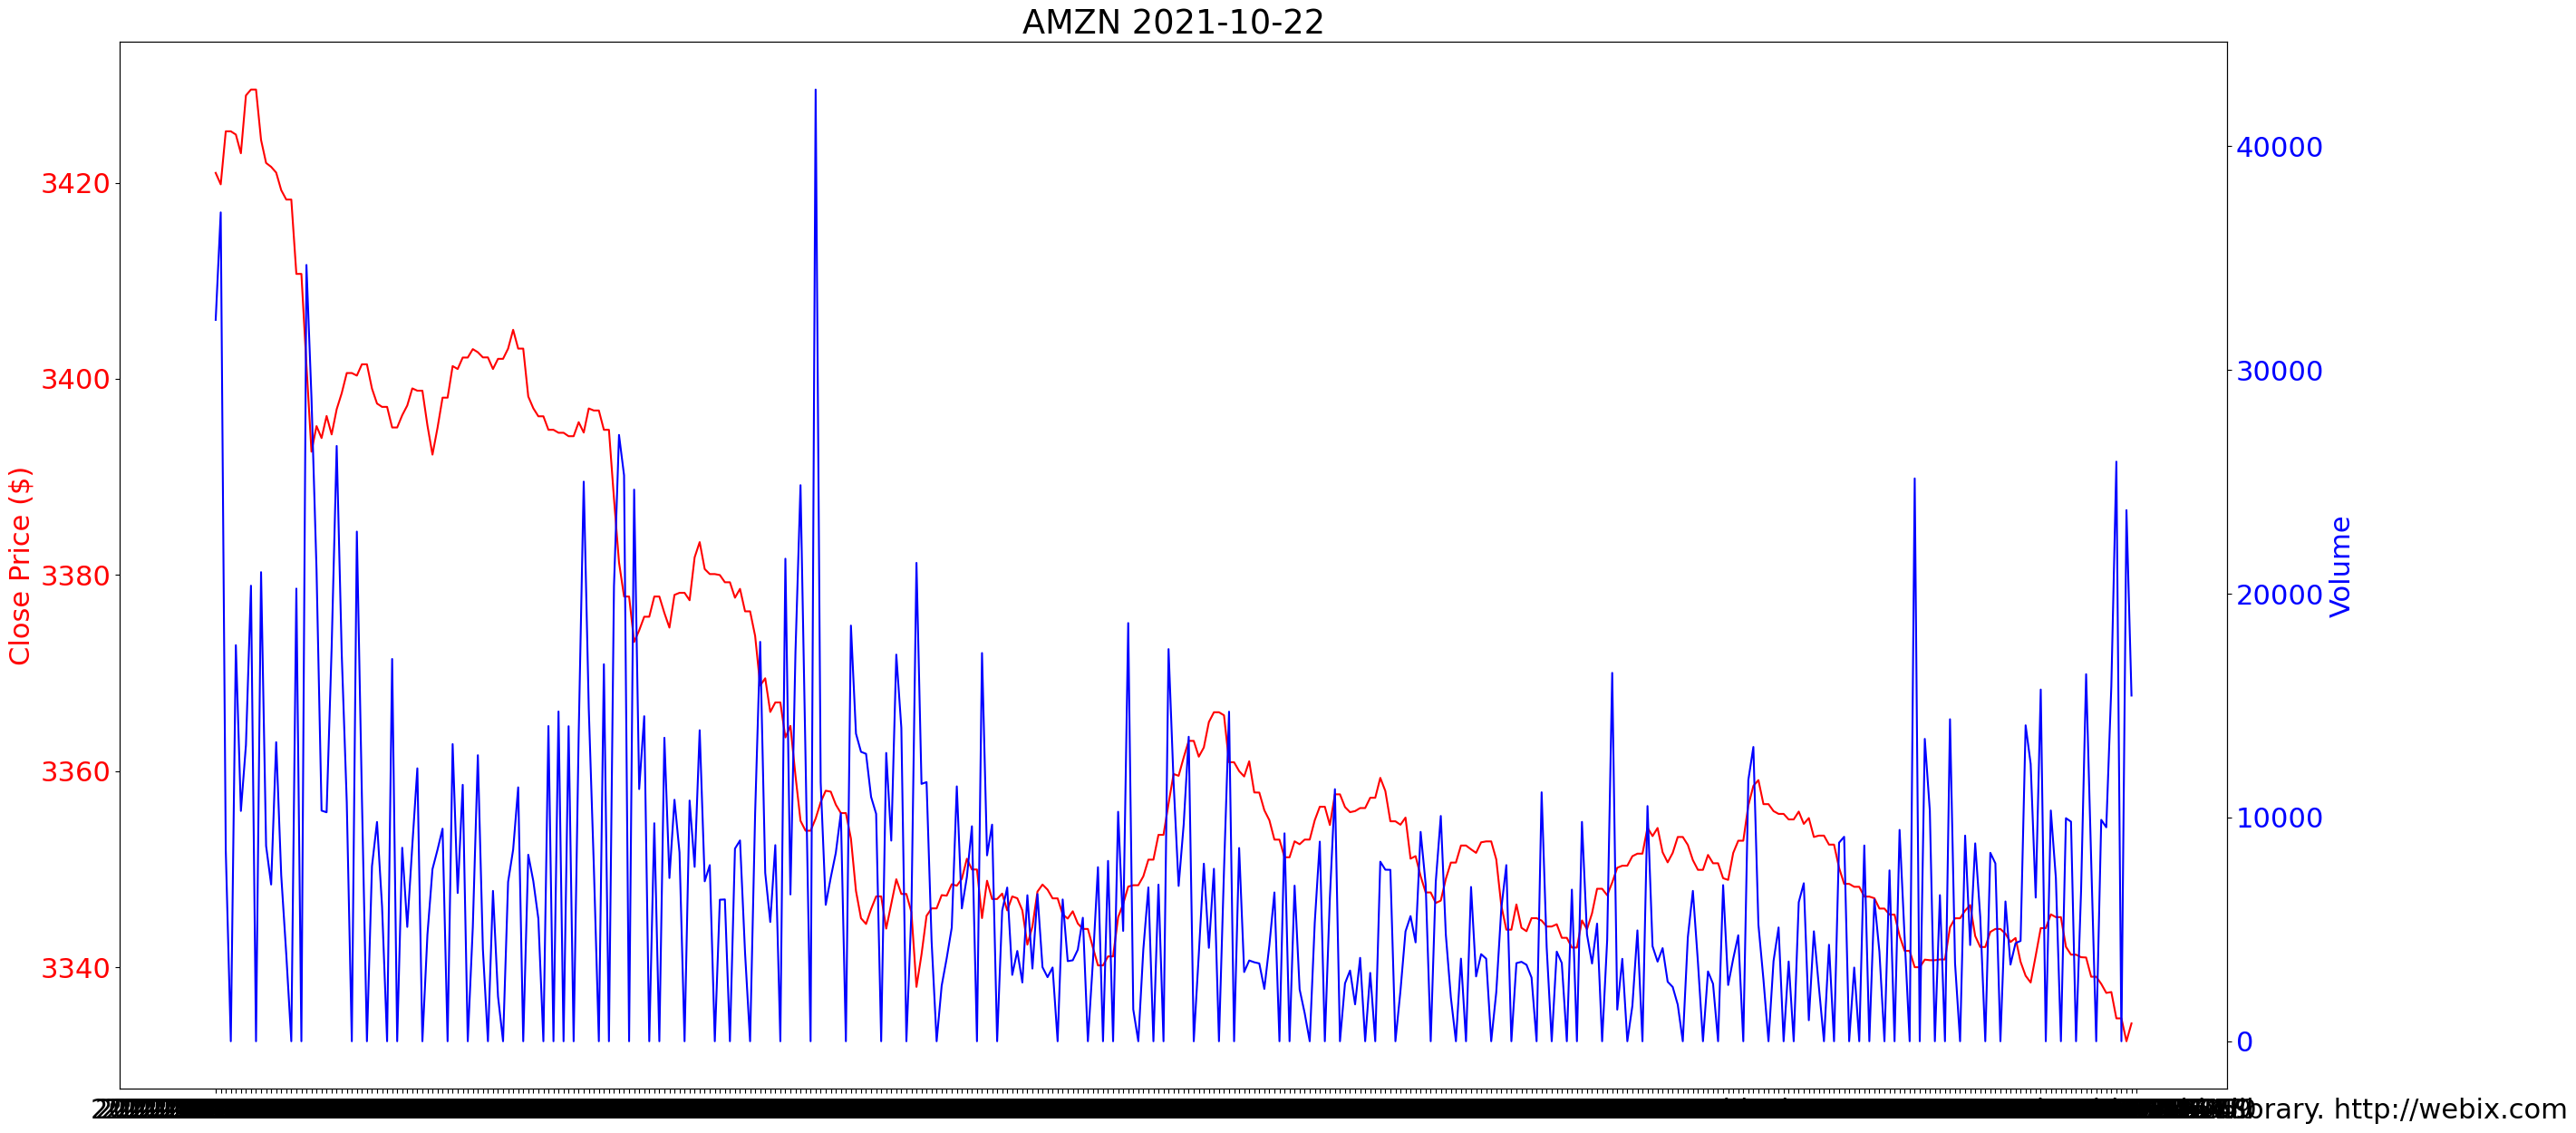

In [8]:
if weekday == True:
    driver = webdriver.Chrome('C:/Users/seant/OneDrive/Desktop/chromedriver_win32/chromedriver.exe')
    
    get_cptv()
    time.sleep(30)
    old_excel_dir = 'C:/Users/seant/Downloads/grid.xls'
    today_data = f'closing_price_trade_volume_data/AMZN_cptv_{today}.xls'
    new_dir = f'C:/Users/seant/stock_analyzer/{today_data}'
    shutil.move(old_excel_dir, new_dir);
    
    real_time_trades_data = get_rtt()
    save_rtt(real_time_trades_data)
    
    driver.quit()
    
    #change x ticks to be by the hour?
    today_table = pd.read_excel(today_data)
    date_array = today_table.loc[:, 'Date']

    plt.rcParams.update({'font.size': 22})
    fig, ax1 = plt.subplots(1, figsize=(30, 15))

    ax1.plot(date_array, today_table.loc[:, 'Close'], color='r', label='Close')
    ax1.set_ylabel('Close Price ($)', color ='r')
    ax1.set_title(f'AMZN {today}')
    ax1.tick_params(axis='y', labelcolor='r')

    ax2 = ax1.twinx()
    ax2.plot(date_array, today_table.loc[:, 'Volume'], color='b', label='Volume')
    ax2.set_ylabel('Volume', color ='b')
    ax2.tick_params(axis='y', labelcolor='b')

    plt.show()
else:
    print('weekend')

Datatable analysis

Only cptv by minute datatable so far